In [23]:
import torch
from model import ClipGPT, VGG, REMOTE_CLIP

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

net = ClipGPT(device=device, encoder=REMOTE_CLIP).to(device)
net.load_state_dict(torch.load('data/models/remote_clip.pth', map_location=device))

Using device: mps


<All keys matched successfully>

In [3]:
from dataset import get_test_datasets

test_datasets = get_test_datasets(net.preprocess)
print(f'Test datasets: {test_datasets.keys()}')

Test datasets: dict_keys(['rsicd', 'ucm', 'nwpu', 'sidney'])


['There are two straight freeways parrallel forward .', 'There are two straight freeways with some plants beside them .', 'Two straight freeways parrallel forward with some plants beside them .', 'Two straight freeways parrallel forward .', 'Two straight freeways parrallel forward with some cars on them .']
torch.Size([3, 224, 224])
['There are two straight freeways closed to each other with some cars on the roads .']


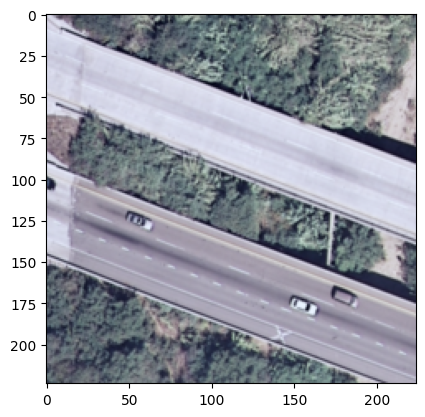

In [30]:
# print one image and text pair
# sample = test_datasets['nwpu'][1200] # --> harbor_641
# sample = test_datasets['nwpu'][1] # --> airplane_631
# sample = test_datasets['nwpu'][457] # --> chaparral_668
# sample = test_datasets['nwpu'][2200] # --> rectangular_farmland_641

# sample = test_datasets['rsicd'][10] # --> airport_357
# sample = test_datasets['rsicd'][88] # --> baseballfield_62
# sample = test_datasets['rsicd'][200] # --> center_64


sample = test_datasets['ucm'][88] # --> 899
# sample = test_datasets['ucm'][200] # --> 2091
# sample = test_datasets['ucm'][120] # --> 1291

# sample = test_datasets['sidney'][30] # --> 356
#sample = test_datasets['sidney'][44] # --> 540
# sample = test_datasets['sidney'][38] # --> 447

# sample = test_datasets['ucm'][120] # --> 1291
print(sample['captions'])
print(sample['x'].shape)

# print image
import matplotlib.pyplot as plt
img = sample['x'].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

# get descritpion
desc = net.get_caption(images=sample['x'].unsqueeze(0).to(device))
print(desc)



In [4]:
from pycocoevalcap.bleu.bleu import Bleu


refs = { 0 : sample['captions']}
res = { 0 : desc }
bleu1_scorer = Bleu(n=4)
bleu1_score = bleu1_scorer.compute_score(refs, res, verbose=False)
print(f'BLEU-1: {bleu1_score}')

# cider
from pycocoevalcap.cider.cider import Cider
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(refs, res)
print(f'CIDEr: {cider_score}')

# rouge
from pycocoevalcap.rouge.rouge import Rouge
rouge_scorer = Rouge()
rouge_score = rouge_scorer.compute_score(refs, res)
print(f'ROUGE: {rouge_score}')


BLEU-1: ([0.4953587997864814, 0.36349398298605734, 0.2121242790025467, 2.944991840635321e-05], [[0.4953587997864814], [0.36349398298605734], [0.2121242790025467], [2.944991840635321e-05]])
CIDEr: 0.0
ROUGE: (0.3674698795180723, array([0.36746988]))


In [5]:
import torch

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Example initialization of tensors with requires_grad=True
Ci = torch.rand(3, requires_grad=True)
Cj = torch.rand(3, requires_grad=True)
Ck1 = torch.rand(3, requires_grad=True)
Ck2 = torch.rand(3, requires_grad=True)

# Ensure no in-place modifications are performed by using clone()
Ci_expanded = Ci[:, None, None, None].clone()  # Shape (3, 1, 1, 1)
Cj_expanded = Cj[None, :, None, None].clone()  # Shape (1, 3, 1, 1)
Ck1_expanded = Ck1[None, None, :, None].clone()  # Shape (1, 1, 3, 1)
Ck2_expanded = Ck2[None, None, None, :].clone()  # Shape (1, 1, 1, 3)

# Verify the shapes to ensure correct broadcasting
print("Ci_expanded shape:", Ci_expanded.shape)
print("Cj_expanded shape:", Cj_expanded.shape)
print("Ck1_expanded shape:", Ck1_expanded.shape)
print("Ck2_expanded shape:", Ck2_expanded.shape)

# Perform the multiplication step by step and check for in-place modifications
eta_step1 = Ci_expanded * Cj_expanded
eta_step2 = eta_step1 * Ck1_expanded
eta = eta_step2 * Ck2_expanded

# Verify the resulting shape
print("eta shape:", eta.shape)

# To verify gradients work correctly, perform a simple backward operation
loss = eta.sum()
loss.backward()

# Check gradients
print("Ci.grad:", Ci.grad)
print("Cj.grad:", Cj.grad)
print("Ck1.grad:", Ck1.grad)
print("Ck2.grad:", Ck2.grad)

Ci_expanded shape: torch.Size([3, 1, 1, 1])
Cj_expanded shape: torch.Size([1, 3, 1, 1])
Ck1_expanded shape: torch.Size([1, 1, 3, 1])
Ck2_expanded shape: torch.Size([1, 1, 1, 3])
eta shape: torch.Size([3, 3, 3, 3])
Ci.grad: tensor([3.8417, 3.8417, 3.8417])
Cj.grad: tensor([4.8280, 4.8280, 4.8280])
Ck1.grad: tensor([2.8806, 2.8806, 2.8806])
Ck2.grad: tensor([5.1803, 5.1803, 5.1803])
